[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


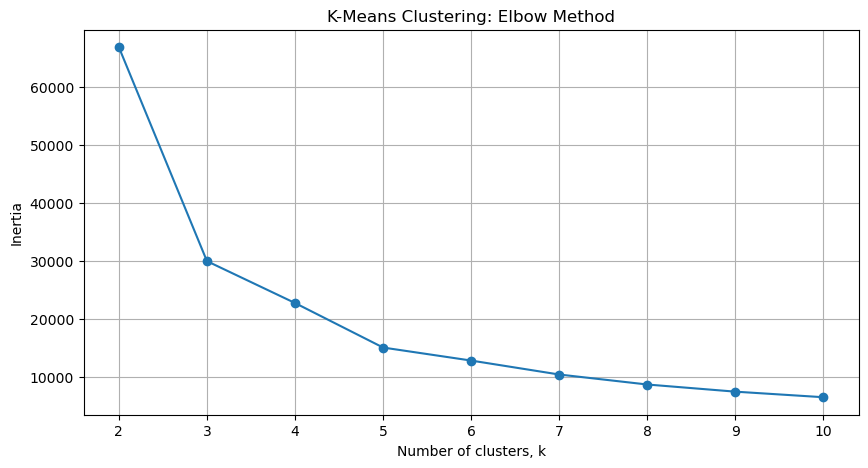

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

# Load the dataset
dataset_path = 'C:/Users/hp/Downloads/GRP_dataset.xlsx'  
data = pd.read_excel(dataset_path)

# Initialize VADER sentiment intensity analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Define function to extract sentiment scores using VADER
def get_vader_sentiment(text):
    if pd.isnull(text):
        return 0  # Return a neutral score for missing text
    score = sia.polarity_scores(str(text))
    return score['compound']

# Apply VADER sentiment analysis to 'reviewText' and 'summary'
data['reviewText_sentiment'] = data['reviewText'].apply(get_vader_sentiment)
data['summary_sentiment'] = data['summary'].apply(get_vader_sentiment)

# Normalize 'overall_rating' and 'price'
scaler = StandardScaler()
data['normalized_rating'] = scaler.fit_transform(data[['overall_rating']])
data['price'] = data['price'].replace('[£$,]', '', regex=True).astype(float)  
data['normalized_price'] = scaler.fit_transform(data[['price']])

# Encode 'verified' as numerical values
data['verified_numeric'] = data['verified'].astype(int)

# Combine features for clustering, now including 'verified_numeric'
features = data[['normalized_rating', 'normalized_price', 'reviewText_sentiment', 'summary_sentiment', 'verified_numeric']]

# Dimensionality Reduction with PCA
pca = PCA(n_components=2) 
features_pca = pca.fit_transform(features)

# Use the elbow method to find the optimal number of clusters
wcss = []
for i in range(2, 11):  
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(features_pca)
    wcss.append(kmeans.inertia_)     #Within Cluster Sum of Squares

# Plot the results of the elbow method
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, '-o')
plt.title('K-Means Clustering: Elbow Method')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(range(2,11))
plt.grid(True)
plt.show()

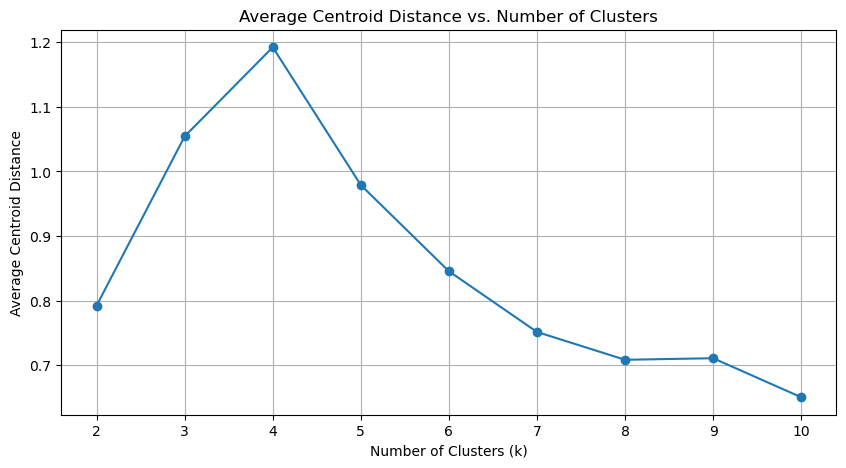

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances

# Function to calculate average centroid distance for each cluster
def calculate_average_centroid_distance(features, labels, centroids):
    distances = pairwise_distances(features, centroids, metric='euclidean')
    total_distance = 0
    for i in range(centroids.shape[0]):  # Loop over each cluster
        # Select distances of points within the current cluster to its centroid
        cluster_distances = distances[labels == i, i]
        # Sum distances within the cluster and divide by number of points in the cluster
        average_distance = np.mean(cluster_distances)
        total_distance += average_distance
    # Return the average distance across all clusters
    return total_distance / centroids.shape[0]

# Apply K-Means clustering for a range of k values and calculate average centroid distances
centroid_distances = []
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_pca)
    avg_distance = calculate_average_centroid_distance(features_pca, kmeans.labels_, kmeans.cluster_centers_)
    centroid_distances.append(avg_distance)

# Plot the average centroid distances for each k value
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), centroid_distances, marker='o')
plt.title('Average Centroid Distance vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Centroid Distance')
plt.grid(True)
plt.show()

Sampled Silhouette Score for k=2: 0.5840
Sampled Silhouette Score for k=3: 0.6306
Sampled Silhouette Score for k=4: 0.6383
Sampled Silhouette Score for k=5: 0.5589
Sampled Silhouette Score for k=6: 0.5685
Sampled Silhouette Score for k=7: 0.5392
Sampled Silhouette Score for k=8: 0.5395
Sampled Silhouette Score for k=9: 0.5374
Sampled Silhouette Score for k=10: 0.5555


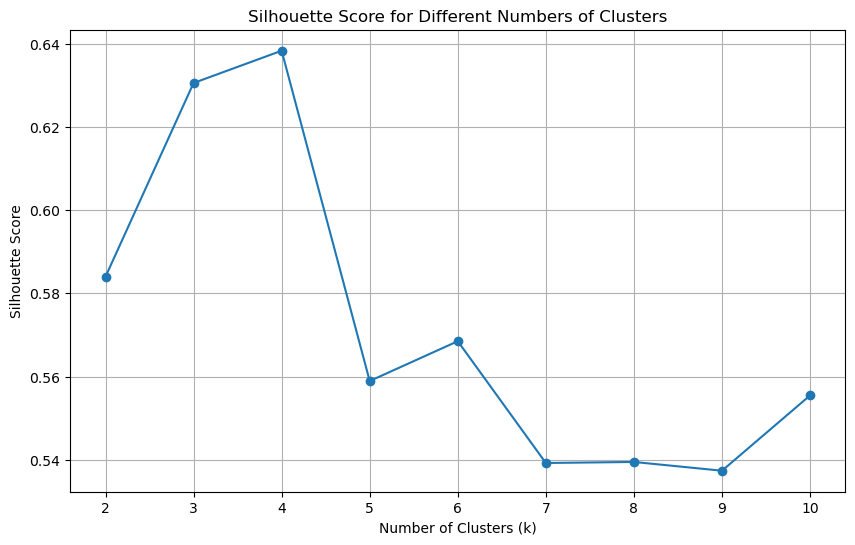

In [ ]:
np.random.seed(42)  # For reproducible sampling

k_values = range(2, 11)  
silhouette_scores = []

for k in k_values:
    # Clustering with current k
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_pca)  

    # Sampling for silhouette calculation
    sample_indices = np.random.choice(range(len(features_pca)), size=min(20000, len(features_pca)), replace=False)
    features_sample = features_pca[sample_indices]
    labels_sample = cluster_labels[sample_indices]

    # Calculate silhouette score on the sample
    silhouette_avg_sampled = silhouette_score(features_sample, labels_sample)
    silhouette_scores.append(silhouette_avg_sampled)
    print(f"Sampled Silhouette Score for k={k}: {silhouette_avg_sampled:.4f}")

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Based on the above statistics(Specifically the ELBOW method), k=4 is the perfect choice for the number of clusters for this particular problem

In [ ]:
from sklearn.metrics import silhouette_score


np.random.seed(42)  # For reproducible results

# Clustering 
kmeans = KMeans(n_clusters=4, random_state=42)
data['cluster_label'] = kmeans.fit_predict(features_pca)  

# Sampling for silhouette calculation
sample_indices = np.random.choice(range(len(features_pca)), size=min(20000, len(features_pca)), replace=False)
features_sample = features_pca[sample_indices]
labels_sample = data['cluster_label'].values[sample_indices]

# Calculate silhouette score on the sample
silhouette_avg_sampled = silhouette_score(features_sample, labels_sample)
print("Sampled Silhouette Score for k=4:", silhouette_avg_sampled)

Sampled Silhouette Score for k=4: 0.6373194712263563


In [ ]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_score

# Extract cluster centers from the KMeans model
centroids = kmeans.cluster_centers_

# Inter-Cluster Analysis: Calculate pairwise centroid distances
centroid_distances = pairwise_distances(centroids)
print("Distances Between Centroids:\n", centroid_distances)

Distances Between Centroids:
 [[ 0.          3.34150802  2.19714444 12.42194666]
 [ 3.34150802  0.          3.77583754  9.09505185]
 [ 2.19714444  3.77583754  0.         12.53120271]
 [12.42194666  9.09505185 12.53120271  0.        ]]


In [ ]:
from sklearn.metrics import pairwise_distances, silhouette_score
import numpy as np

# Function to calculate the average distance within clusters using a sample
def calculate_sampled_avg_intracluster_distance(features, labels, sample_size=2000):
    unique_labels = np.unique(labels)
    avg_distances = np.zeros(len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        # Extract a sample of features for the current cluster
        cluster_features = features[labels == label]
        if len(cluster_features) > sample_size:
            np.random.seed(42)  # Ensure reproducibility
            indices = np.random.choice(cluster_features.shape[0], size=sample_size, replace=False)
            cluster_sample = cluster_features[indices]
        else:
            cluster_sample = cluster_features
        
        # Calculate pairwise distances for the sampled points in the cluster
        if len(cluster_sample) > 1:  # Ensure there are at least two samples to compute distances
            distances = pairwise_distances(cluster_sample)
            np.fill_diagonal(distances, np.nan)  # Ignore distance to self
            avg_distances[i] = np.nanmean(distances)
    
    return avg_distances

# Calculate the sampled average intra-cluster distances
avg_distances = calculate_sampled_avg_intracluster_distance(features_pca, data['cluster_label'].values)
print("Sampled Average Intra-Cluster Distances:", avg_distances)

Sampled Average Intra-Cluster Distances: [0.64980898 1.79580095 1.03791075 2.85325722]


In [ ]:
# Initialize VADER sentiment intensity analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Define function to extract sentiment scores using VADER
def get_vader_sentiment(text):
    if pd.isnull(text):
        return 0  # Return a neutral score for missing text
    score = sia.polarity_scores(str(text))
    return score['compound']  # Use the compound score

# Apply VADER sentiment analysis to 'reviewText' and 'summary'
data['reviewText_sentiment'] = data['reviewText'].apply(get_vader_sentiment)
data['summary_sentiment'] = data['summary'].apply(get_vader_sentiment)

# Normalize 'overall_rating' and 'price'
scaler = StandardScaler()
data['normalized_rating'] = scaler.fit_transform(data[['overall_rating']])
data['price'] = data['price'].replace('[£$,]', '', regex=True).astype(float)  # Adjust regex for currency symbols
data['normalized_price'] = scaler.fit_transform(data[['price']])

# Encode 'verified' as numerical values
data['verified_numeric'] = data['verified'].astype(int)

# Combine features for clustering, now including 'verified_numeric'
features = data[['normalized_rating', 'normalized_price', 'reviewText_sentiment', 'summary_sentiment', 'verified_numeric']]

# Dimensionality Reduction with PCA
pca = PCA(n_components=2)  
features_pca = pca.fit_transform(features)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42).fit(features_pca)
data['cluster_label'] = kmeans.labels_

# Display the first few rows of the DataFrame to verify
data[['reviewText', 'summary', 'overall_rating', 'price', 'verified','cluster_label']].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,reviewText,summary,overall_rating,price,verified,cluster_label
0,they are gift cards,Five Stars,5,25.0,True,0
1,I ordered a bunch of gift cards and when the p...,You need to double check all gift cards!!!,2,25.0,True,2
2,Great,Five Stars,5,25.0,True,0
3,love getting 5% back buying giftcards when I u...,Five Stars,5,25.0,True,0
4,gift,Five Stars,5,25.0,True,0


In [ ]:
# Analyze average values in each cluster
cluster_analysis = data.groupby('cluster_label').mean()
cluster_analysis

,index_column,overall_rating,reviewTime,verified,price,reviewCount,reviewText_sentiment,summary_sentiment,normalized_rating,normalized_price,verified_numeric
cluster_label,,,,,,,,,,,
0,21990.978823,4.734576,2001.168915,0.880716,17.953665,282.342887,0.499236,0.288477,0.474946,-0.165520,0.880716
1,22164.413774,4.304683,2001.775758,0.748760,147.554567,166.387328,0.431976,0.209514,0.120986,3.164159,0.748760
2,25616.173811,2.143468,1999.196212,0.663273,18.519181,269.761328,0.090645,0.019735,-1.658493,-0.150991,0.663273
3,20976.027523,4.275229,1993.357798,0.623853,501.522936,48.926606,0.402075,0.224846,0.096734,12.258239,0.623853


In [ ]:
# Calculate the mean sentiment score and rating for each cluster
cluster_means = data.groupby('cluster_label').mean()[['reviewText_sentiment', 'normalized_rating', 'normalized_price']]

# Display the mean values for each cluster
cluster_means

,reviewText_sentiment,normalized_rating,normalized_price
cluster_label,,,
0,0.499236,0.474946,-0.165520
1,0.431976,0.120986,3.164159
2,0.090645,-1.658493,-0.150991
3,0.402075,0.096734,12.258239


In [ ]:
# Define favorable clusters
favorable_clusters = [0, 1, 3]

# Label products as 'Recommended' or 'Not Recommended'
data['recommendation'] = data['cluster_label'].apply(lambda x: 'Recommended' if x in favorable_clusters else 'Not Recommended')

In [ ]:
# Group by 'asin' and aggregate the other fields, ensuring all text entries are strings
grouped_data = data.groupby('asin').agg({
    'title': 'first',  # The first title in each group is representative
    'brand': 'first',  # The first brand in each group is representative
    'category': 'first',  # The first category in each group is representative
    'reviewText': lambda x: ' '.join(x.astype(str)),  # Convert to string and concatenate all review texts
    'summary': lambda x: ' '.join(x.astype(str)),  # Convert to string and concatenate all summaries
    'overall_rating': 'mean',  # Calculates the mean of overall ratings
    'price': 'mean',  # Calculates the mean price
    'recommendation': lambda x: x.mode()[0] if not x.mode().empty else 'Not Recommended'  # recommendation
}).reset_index()

# Display the specific columns of the grouped data
display_columns = grouped_data[['asin', 'title', 'brand', 'category', 'overall_rating', 'price', 'recommendation']]
display_columns

,asin,title,brand,category,overall_rating,price,recommendation
0,0763855553,Microsoft Office 365 Home | 1-year subscriptio...,Microsoft,Software,3.870968,90.050000,Recommended
1,B00004U9V2,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,Crabtree,Luxury Beauty,4.739130,30.000000,Recommended
2,B000050ZRE,Key Span 4-Port USB Hub - White (UH-4WH),Keyspan,Software,4.907514,90.090116,Recommended
3,B00005MOTE,Microsoft Windows XP Home Edition Upgrade - Ol...,Microsoft,Software,3.000000,48.267778,Not Recommended
4,B000068DWY,"Calvin Klein ck one Eau de Toilette, 3.4 fl. oz.",Calvin,Luxury Beauty,4.500000,64.000000,Recommended
...,...,...,...,...,...,...,...
667,B01GDUM6UC,Vichy Aqualia Thermal Mineral Water Gel Moistu...,Vichy,Luxury Beauty,3.571429,35.210000,Recommended
668,B01GOZ61O8,TIZO Photoceutical AM Replenish SPF 40 Sunscre...,TIZO,Luxury Beauty,3.800000,49.990000,Recommended
669,B01H353A74,Vita Liberata Body Blur Instant HD Skin Finish...,Vita,Luxury Beauty,3.350000,45.000000,Not Recommended
670,B01H353FLA,Patchology Detox SmartMud No Mess Mud Sheet Ma...,Patchology,Luxury Beauty,3.631579,30.000000,Recommended


In [ ]:
# Calculate mean values for overall_rating, price, and reviewText_sentiment for each cluster
cluster_summary = data.groupby('cluster_label').agg({
    'overall_rating': 'mean',
    'price': 'mean',
    'reviewText_sentiment': 'mean',
    'recommendation': lambda x: x.value_counts()  # Counts the occurrences of each recommendation status
}).reset_index()

# Renaming for clarity
cluster_summary.rename(columns={
    'overall_rating': 'Mean Rating',
    'price': 'Mean Price',
    'reviewText_sentiment': 'Mean Sentiment Score',
    'recommendation': 'Recommendation Counts'
}, inplace=True)

# Display the cluster summary
cluster_summary

,cluster_label,Mean Rating,Mean Price,Mean Sentiment Score,Recommendation Counts
0,0,4.734576,17.953665,0.499236,33810
1,1,4.304683,147.554567,0.431976,1815
2,2,2.143468,18.519181,0.090645,9821
3,3,4.275229,501.522936,0.402075,109


In [ ]:
# Frequency distribution of 'category' within each cluster
category_distribution = data.groupby(['cluster_label', 'category']).size().unstack(fill_value=0)

print("Frequency Distribution of Categories within Each Cluster:\n")
category_distribution

Frequency Distribution of Categories within Each Cluster:



category,All Beauty,Gift Cards,Industrial & Scientific,Luxury Beauty,Prime Pantry,Software
cluster_label,,,,,,
0,11619,1745,6295,10788,1409,1954
1,357,101,221,503,0,633
2,4443,38,716,3512,209,903
3,0,55,0,54,0,0


### Cluster Summaries:
1. **Cluster 0:**
   - **Mean Rating:** 4.73 (High)
   - **Mean Price:** £17.95 (Low)
   - **Mean Sentiment Score:** 0.50 (Positive)
   - **Recommendation Counts:** 33,810 (Highly Recommended)
   - **Category Distribution:**
     - Mostly "All Beauty", "Luxury Beauty", and significant counts in "Industrial & Scientific", and "Gift Cards".
     - This cluster seems to represent common, low-cost beauty and industrial products that are well-received, generally positive in sentiment.

2. **Cluster 1:**
   - **Mean Rating:** 4.30 (Moderately High)
   - **Mean Price:** £147.55 (Moderate)
   - **Mean Sentiment Score:** 0.43 (Positive)
   - **Recommendation Counts:** 1,815
   - **Category Distribution:**
     - Includes "All Beauty", "Luxury Beauty", and "Software".
     - This cluster appears to include more premium beauty products and software, moderately priced and generally positive but with fewer recommendations, suggesting niche or less universally appealing items.

3. **Cluster 2:**
   - **Mean Rating:** 2.14 (Low)
   - **Mean Price:** £18.52 (Low)
   - **Mean Sentiment Score:** 0.09 (Neutral/Negative)
   - **Recommendation Counts:** 9,821
   - **Category Distribution:**
     - Strong presence in "All Beauty" and "Luxury Beauty" with some "Industrial & Scientific".
     - This cluster characterizes poorly received products, low in cost but also low in customer satisfaction, reflected by a low sentiment score.

4. **Cluster 3:**
   - **Mean Rating:** 4.28 (Moderately High)
   - **Mean Price:** £501.52 (High)
   - **Mean Sentiment Score:** 0.40 (Positive)
   - **Recommendation Counts:** 109 (Exclusively Recommended)
   - **Category Distribution:**
     - Focused on "Luxury Beauty" and "Gift Cards".
     - Represents highly premium products, expensive and with moderate to high ratings, but very few in number, suggesting highly specialized luxury items.

### Interpretation:
- **Cluster 0** is likely popular, everyday beauty products and practical items that are both affordable and highly recommended by users.
- **Cluster 1** features more expensive, quality beauty products and software, appreciated by users but perhaps less popular or more specialized than those in Cluster 0.
- **Cluster 2** seems to include the least favored products, where despite being affordable, the customer satisfaction and sentiment are notably low.
- **Cluster 3** captures the high-end market segment with expensive, luxury items that though rated fairly positively, are recommended by a very small group of customers, indicating exclusivity and niche appeal.

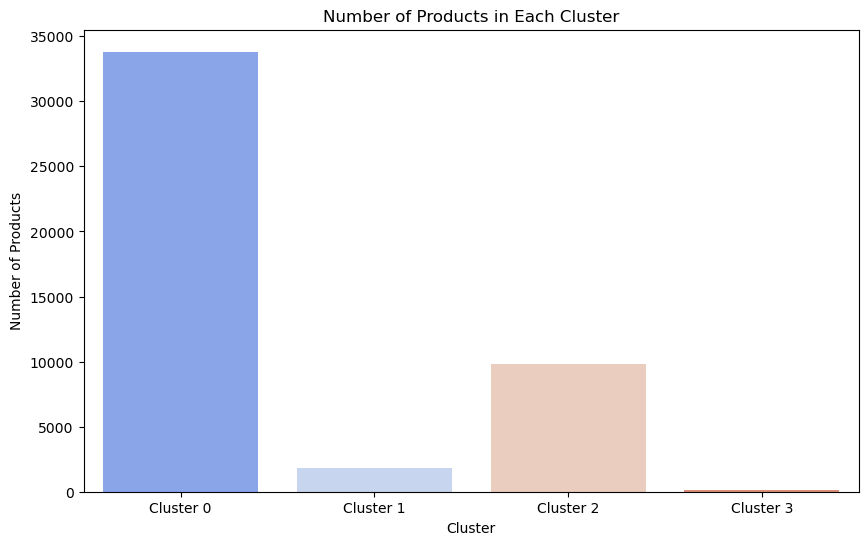

<Figure size 1000x600 with 0 Axes>

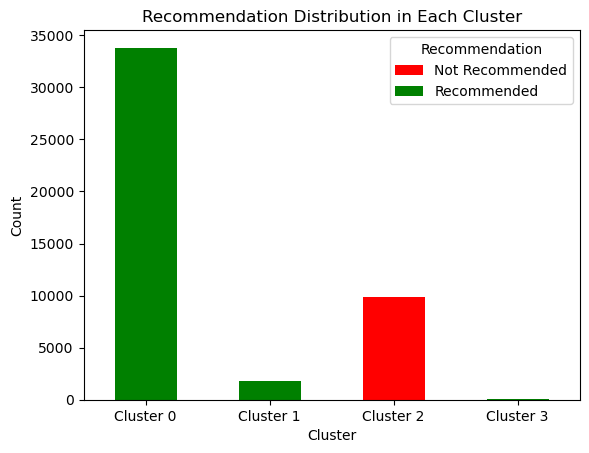

In [ ]:
# Cluster Count Bar Chart
# Count the number of products in each cluster
import matplotlib.pyplot as plt
import seaborn as sns

cluster_counts = data['cluster_label'].value_counts().sort_index()

# Plotting the cluster counts
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='coolwarm')
plt.title('Number of Products in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Products')
plt.xticks(range(len(cluster_counts.index)), labels=['Cluster ' + str(i) for i in cluster_counts.index])

plt.show()

# Recommendation Distribution
# Count the number of recommendations ('Recommended' or 'Not Recommended') in each cluster
recommendation_distribution = data.groupby(['cluster_label', 'recommendation']).size().unstack(fill_value=0)

# Plotting the recommendation distribution
plt.figure(figsize=(10, 6))
recommendation_distribution.plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Recommendation Distribution in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(len(recommendation_distribution.index)), labels=['Cluster ' + str(i) for i in recommendation_distribution.index], rotation=0)

plt.legend(title='Recommendation')
plt.show()

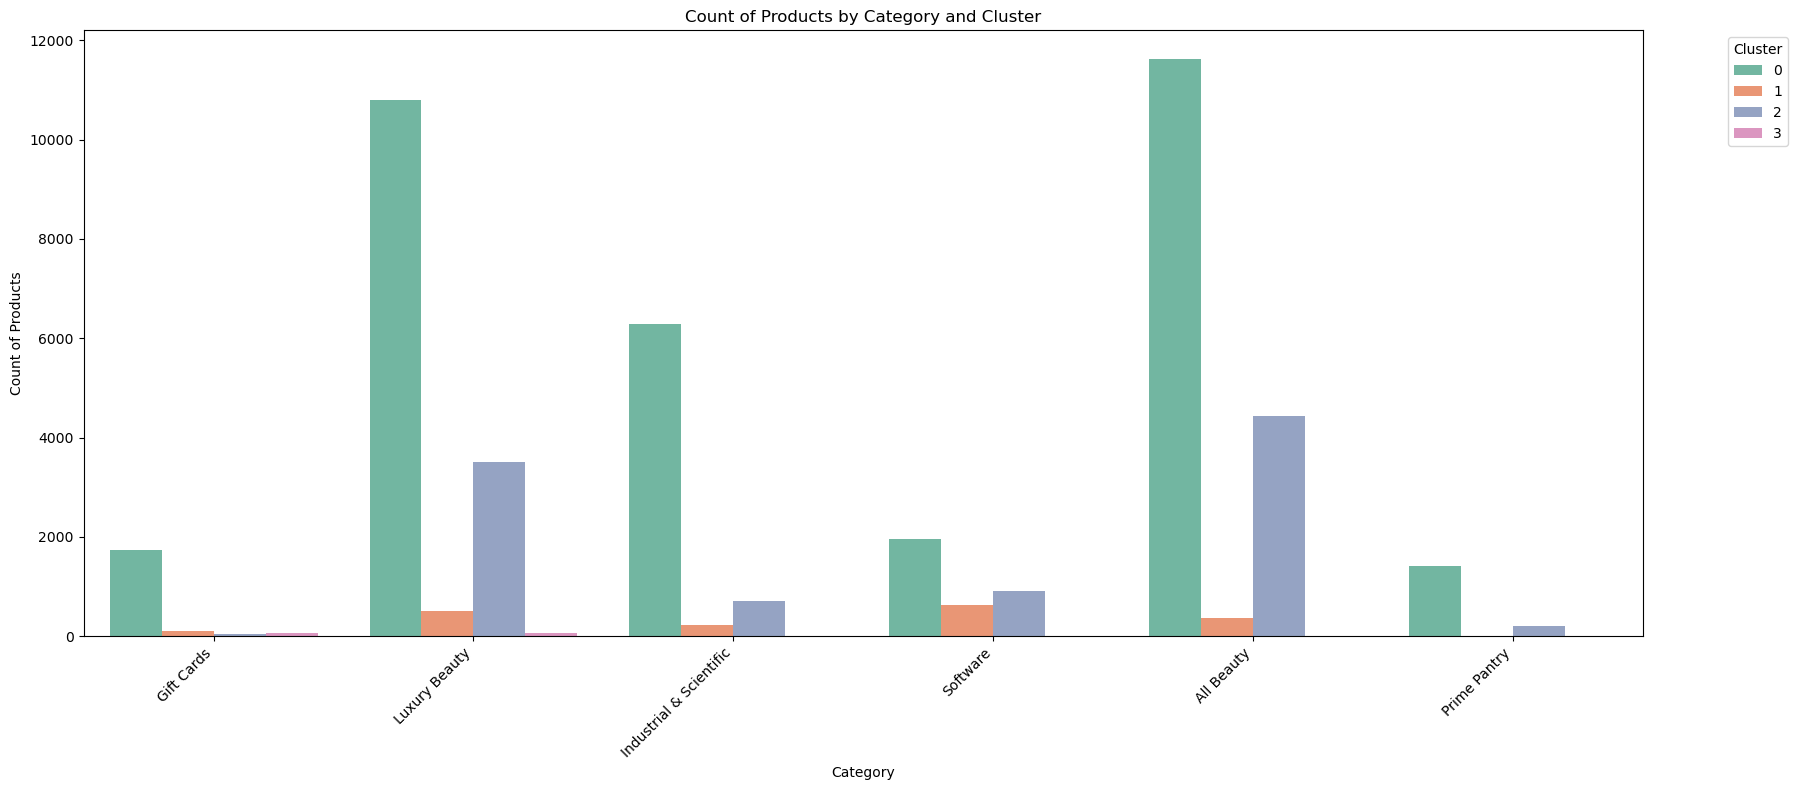

In [ ]:
# Count of Products by Category and Cluster
plt.figure(figsize=(18, 8))
sns.countplot(x='category', hue='cluster_label', data=data, palette='Set2')
plt.title('Count of Products by Category and Cluster')
plt.xlabel('Category')
plt.ylabel('Count of Products')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


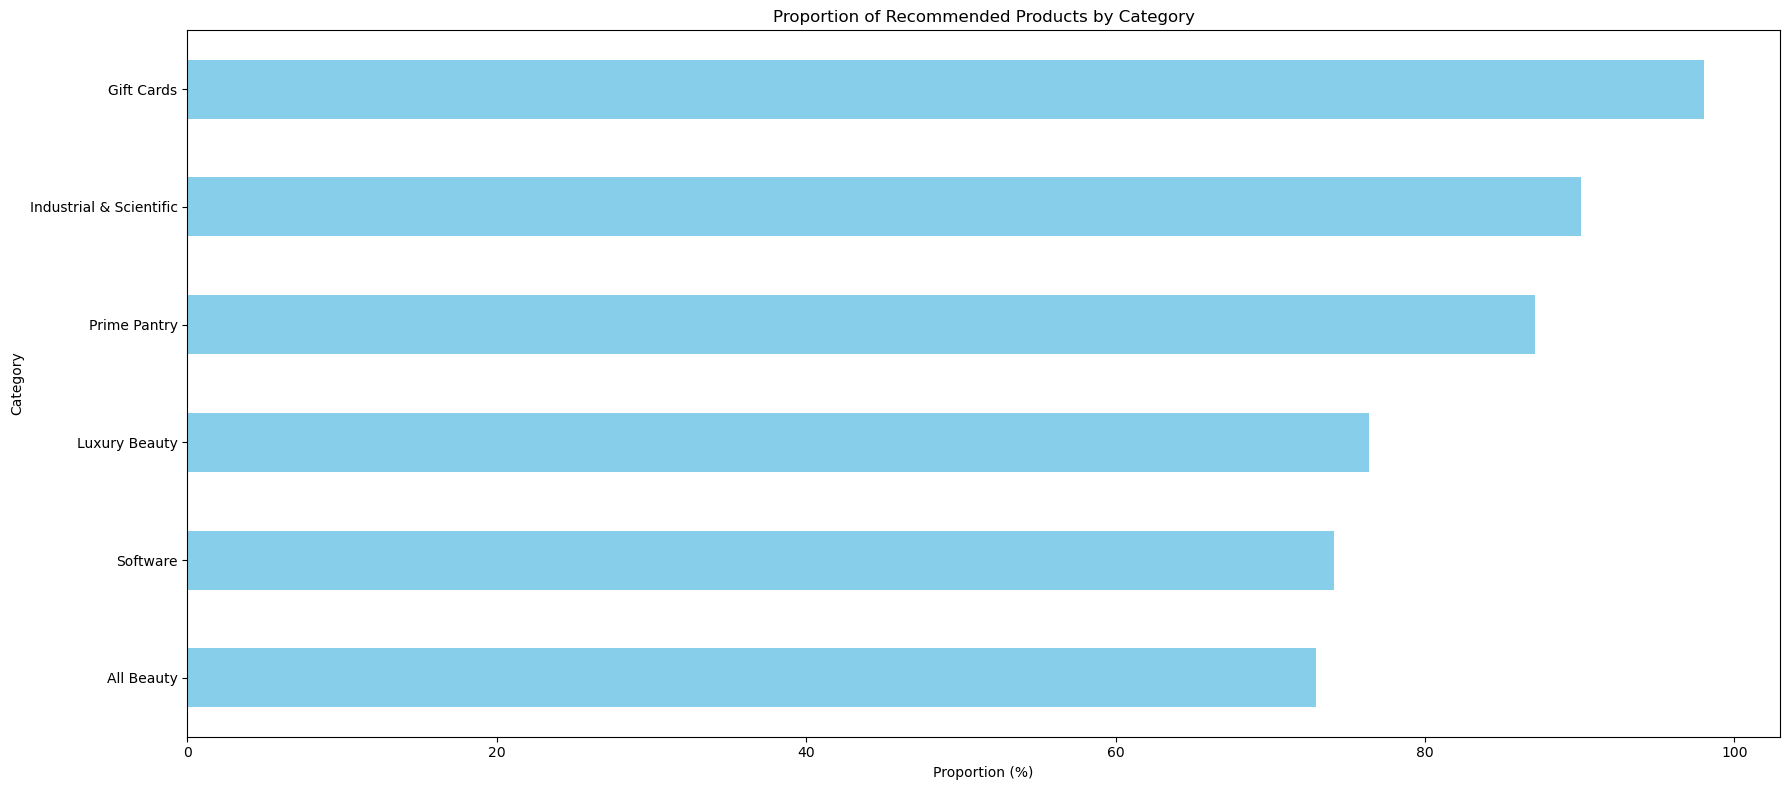

In [ ]:
# Proportion of Recommended Products by Category
# Calculate the proportion of recommended products within each category
category_recommendation = data.groupby('category')['recommendation'].value_counts(normalize=True).unstack(fill_value=0) * 100

# Plotting the proportion of recommended products by category
plt.figure(figsize=(18, 8))
category_recommendation['Recommended'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Proportion of Recommended Products by Category')
plt.xlabel('Proportion (%)')
plt.ylabel('Category')

plt.tight_layout()
plt.show()

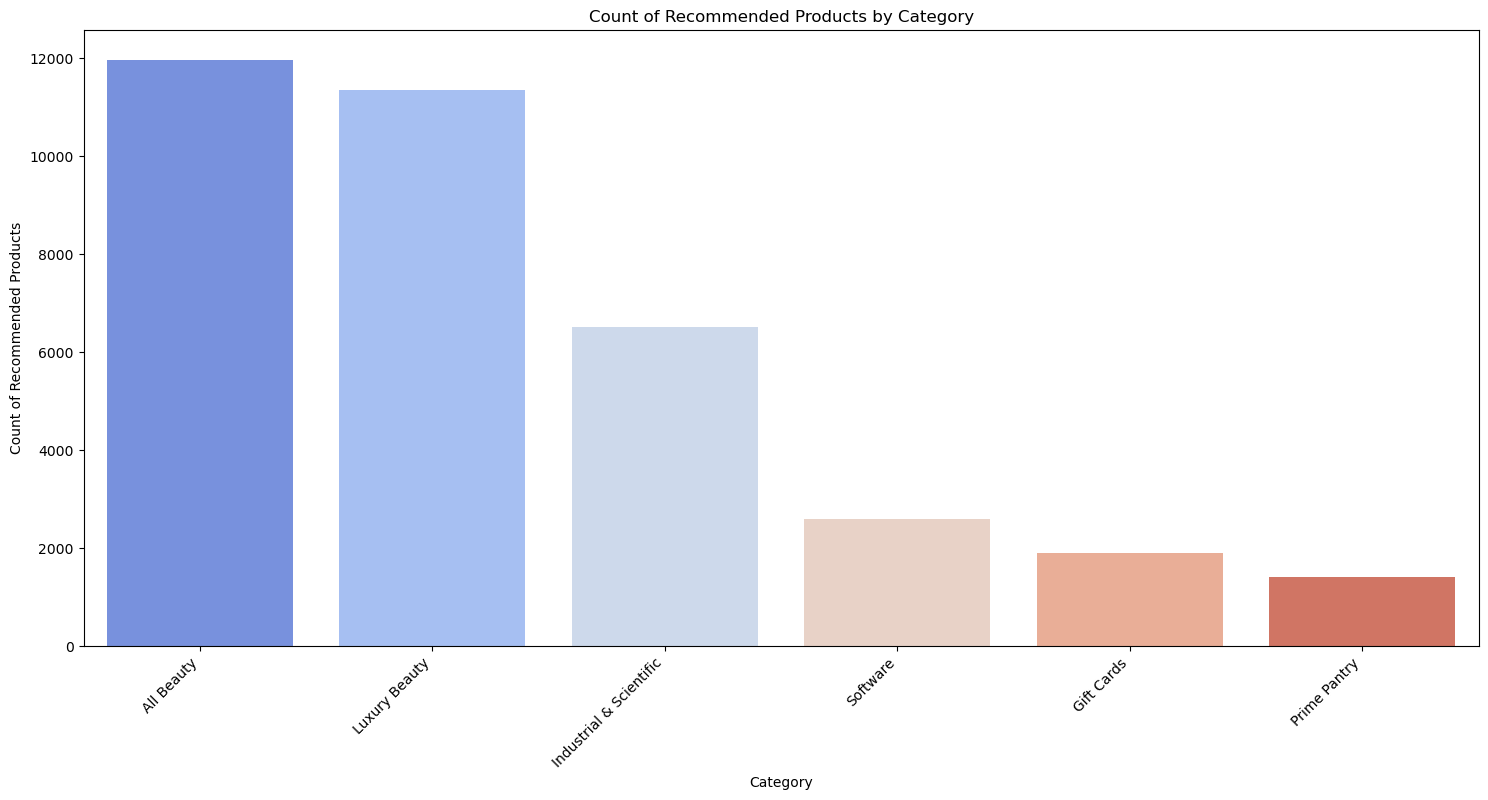

In [ ]:
# Filtering the data for only recommended products
recommended_products = data[data['recommendation'] == 'Recommended']

# Counting the number of recommended products in each category
recommended_counts = recommended_products['category'].value_counts().sort_values(ascending=False)

# Plotting the count of recommended products by category
plt.figure(figsize=(18, 8))
sns.barplot(x=recommended_counts.index, y=recommended_counts.values, palette='coolwarm')
plt.title('Count of Recommended Products by Category')
plt.xlabel('Category')
plt.ylabel('Count of Recommended Products')
plt.xticks(rotation=45, ha='right')

plt.show()

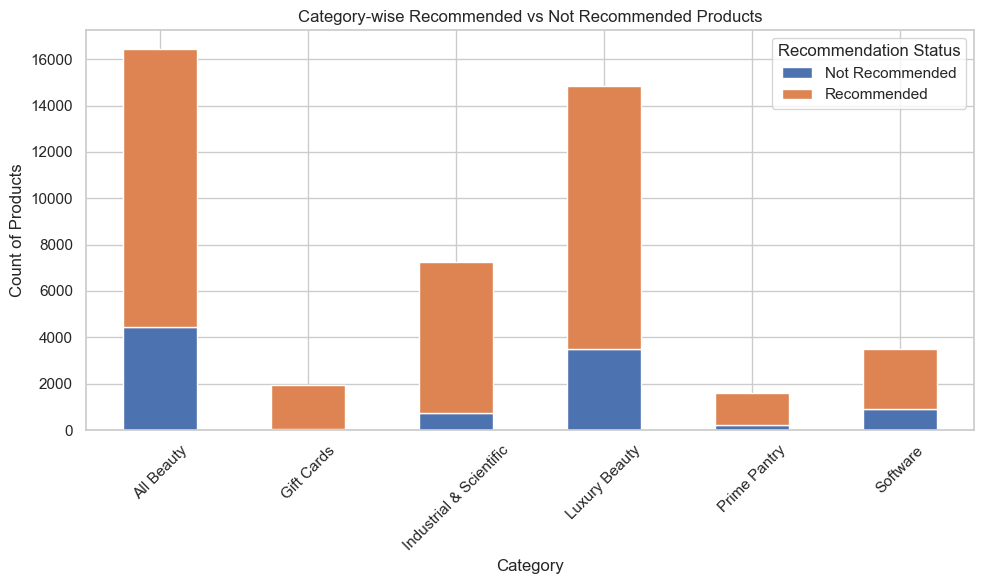

In [ ]:
# Counting the number of recommended and not recommended products by category
recommendation_count = data.groupby(['category', 'recommendation']).size().unstack(fill_value=0)

# Plotting
recommendation_count.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Category-wise Recommended vs Not Recommended Products')
plt.xlabel('Category')
plt.ylabel('Count of Products')
plt.xticks(rotation=45)
plt.legend(title='Recommendation Status')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


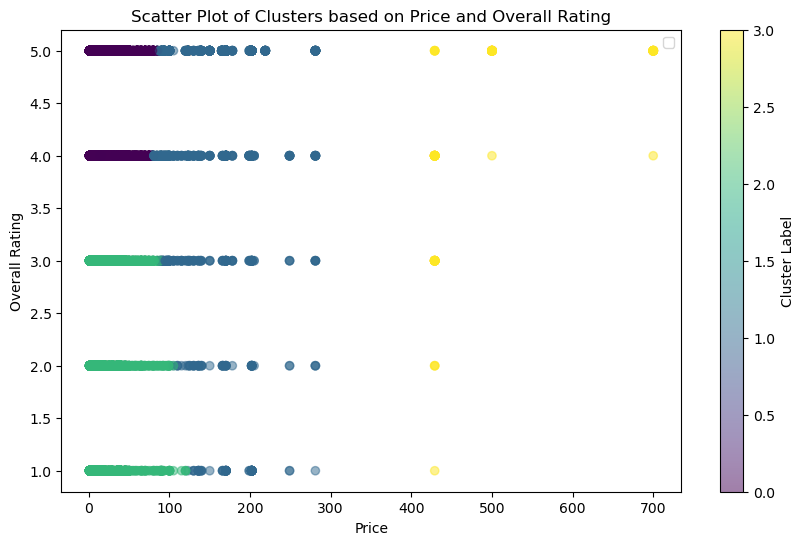

In [ ]:
# Scatter plot of the data with cluster labels as color
plt.figure(figsize=(10, 6))
plt.scatter(data['price'], data['overall_rating'], c=data['cluster_label'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster Label')
plt.xlabel('Price')
plt.ylabel('Overall Rating')
plt.title('Scatter Plot of Clusters based on Price and Overall Rating')
plt.legend()
plt.show()

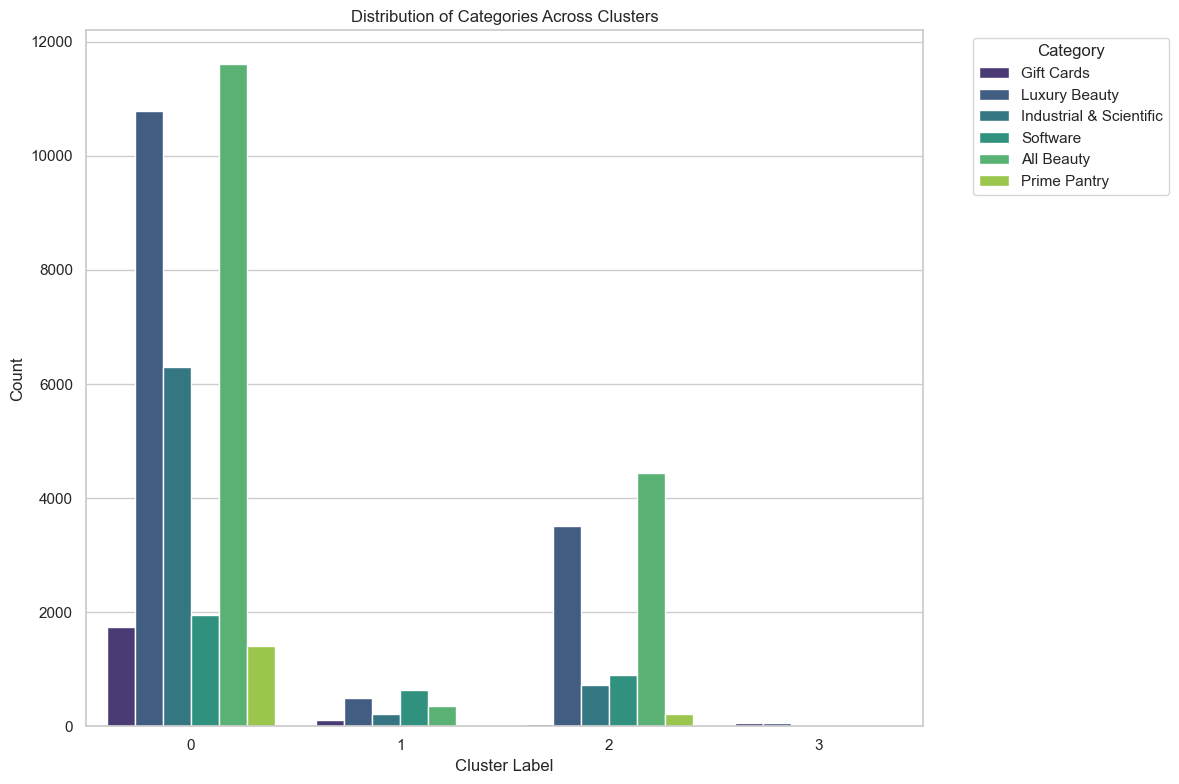

In [ ]:
#Countplot of the distribution of categories across cluster 
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='cluster_label', hue='category', palette='viridis')
plt.title('Distribution of Categories Across Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot

plt.tight_layout()
plt.show()

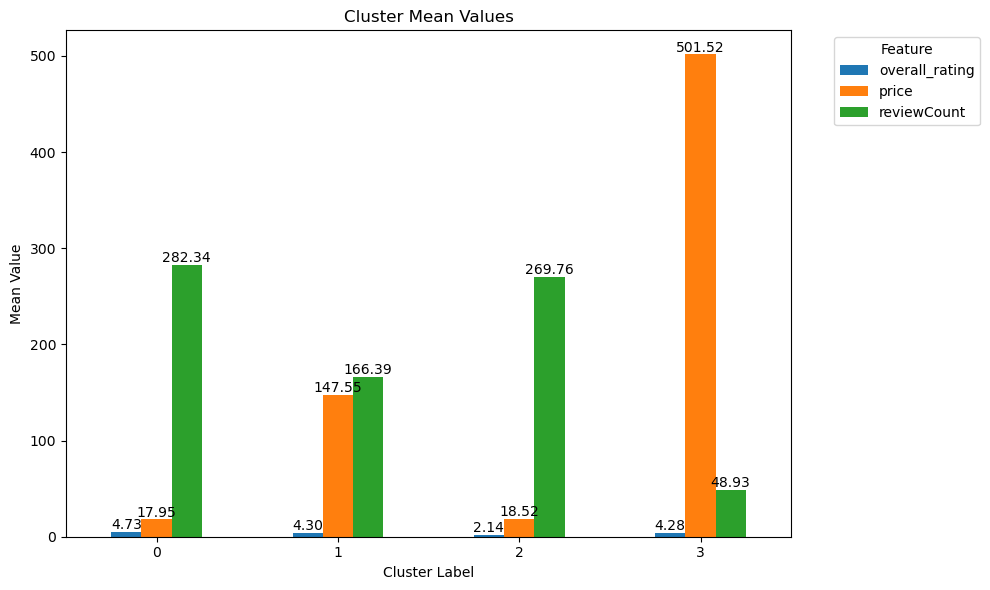

In [ ]:
# Calculate mean values for each cluster
cluster_means = data.groupby('cluster_label').mean()[['overall_rating', 'price', 'reviewCount']]
# Plotting with capturing the axis (ax)
fig, ax = plt.subplots(figsize=(10, 6))
cluster_means.plot(kind='bar', ax=ax)
plt.title('Cluster Mean Values')
plt.xlabel('Cluster Label')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Annotating the bars with a check for NaN values and displaying as integer or float
for p in ax.patches:
    height = p.get_height()
    if pd.notnull(height):  # Check if height is not NaN
        # Display as integer if the decimal part is 0; otherwise, display as float
        label = f'{int(height)}' if height.is_integer() else f'{height:.2f}'
        ax.annotate(label, (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    else:
        print(f"Skipping annotation for NaN value at {p.get_x()}")

# Show plot
plt.tight_layout()
plt.show()

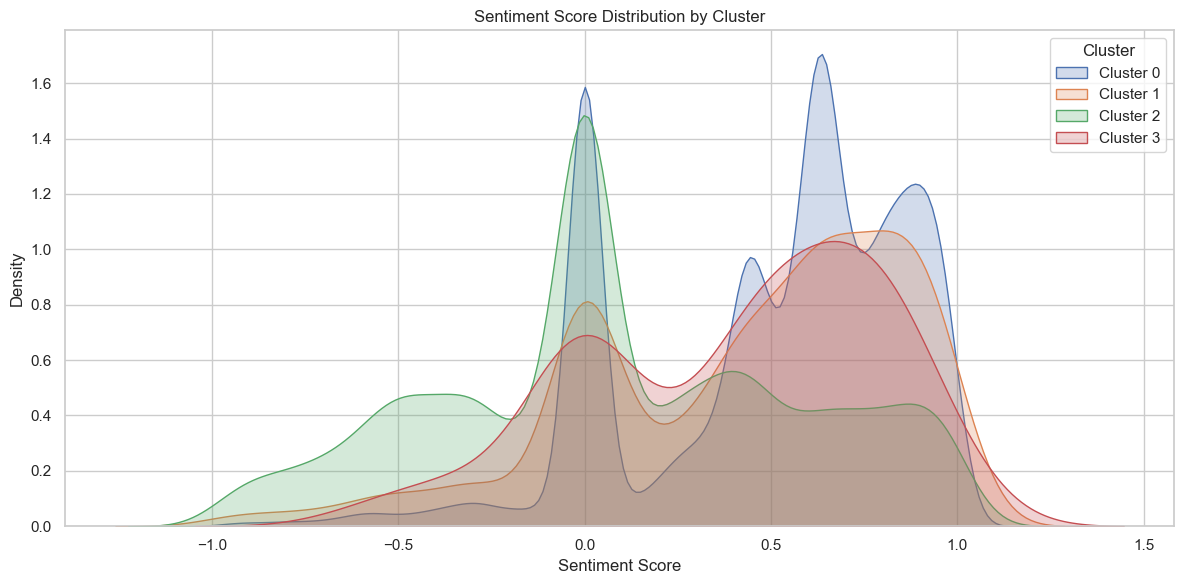

In [ ]:
# Plotting the Sentiment Score Distribution for each cluster
sns.set(style="whitegrid")  # Setting the seaborn style for better aesthetics
plt.figure(figsize=(12, 6))

# Plotting density plots for each cluster
for cluster in sorted(data['cluster_label'].unique()):
    sns.kdeplot(data[data['cluster_label'] == cluster]['reviewText_sentiment'], label=f'Cluster {cluster}', shade=True)

plt.title('Sentiment Score Distribution by Cluster')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend(title='Cluster')
plt.tight_layout()

# Show plot
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ea42f488-32e8-4a8d-9e6d-e3bf40f3e1bb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>